In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
import h5py
from model_1p4 import *

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

In [2]:
monkey = 'V'
session =0
block = 1
param_config = 'load'
seed_network = session if monkey=='V' else session + 100
seed_reward = block + 100*session + 1000 if monkey=='V' else block + 100*session + 2000
if param_config=='load':
    with open("data/rl_fitted_params.json") as f:
        params = json.load(f)[monkey][str(session)]
    params['ff'] = 0.4
    params['thresh'] = 0.0

env = Environment(monkey=monkey, session=session, block=block, seed_reward=seed_reward, params=params, perturb=0)
net = build_network(env, seed_network=seed_network)
sim = nengo.Simulator(net, dt=env.dt, progress_bar=False)
with sim:
    for trial in range(1,20):
        net.env.set_cue(block, trial)
        sim.run(net.env.t_cue)
        env.set_action(sim, net)
        env.set_reward(block, trial)
        sim.run(net.env.t_reward)

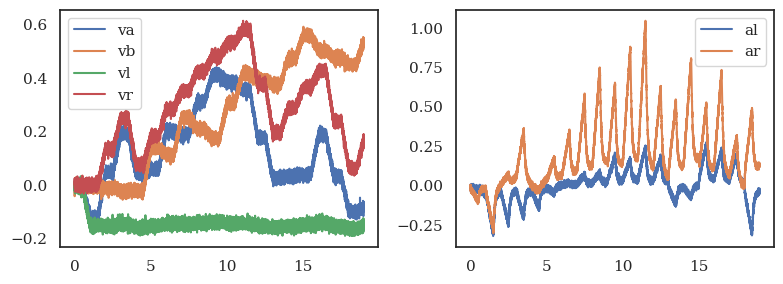

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), sharex=True)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,0], label='va')
axes[0].plot(sim.trange(), sim.data[net.p_v][:,1], label='vb')
axes[0].plot(sim.trange(), sim.data[net.p_v][:,2], label='vl')
axes[0].plot(sim.trange(), sim.data[net.p_v][:,3], label='vr')
axes[1].plot(sim.trange(), sim.data[net.p_a][:,0], label='al')
axes[1].plot(sim.trange(), sim.data[net.p_a][:,1], label='ar')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

In [4]:
def run_dynamics(monkey='V', session=0, block=1):
    seed_network = session if monkey=='V' else session + 100
    seed_reward = block + 100*session + 1000 if monkey=='V' else block + 100*session + 2000
    rng_network = np.random.RandomState(seed=seed_network)
    params = {
        'alpha_v':rng_network.uniform(0.4, 0.6),
        'gamma_v':rng_network.uniform(0.9, 1.0),
        'w0':rng_network.uniform(0.4, 0.6),
        'alpha_w':rng_network.uniform(0.3, 0.5),
        'gamma_w':rng_network.uniform(0.05, 0.10),
        'ff': 0.3,
    }
    env = Environment(monkey=monkey, session=session, block=block, seed_reward=seed_reward, params=params, perturb=0)
    net = build_network(env, seed_network=seed_network)
    sim = nengo.Simulator(net, dt=net.env.dt, progress_bar=False)
    values, spikes = simulate_values_spikes(net)
    return values, spikes

In [5]:
def plot_dynamics(values):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharey=False, sharex=True, figsize=(14, 4))
    sns.lineplot(values, x='trial_rev', y='va',ax=axes[0], color=palette[0], label='a')
    sns.lineplot(values, x='trial_rev', y='vb',ax=axes[0], color=palette[1], label='b')
    sns.lineplot(values, x='trial_rev', y='vl',ax=axes[0], color=palette[2], label='l')
    sns.lineplot(values, x='trial_rev', y='vr',ax=axes[0], color=palette[3], label='r')
    sns.lineplot(values, x='trial_rev', y='omega',ax=axes[1], color=palette[0])
    # sns.lineplot(values, x='trial_rev', y='ev',ax=axes[1], color=palette[0])
    # sns.lineplot(values, x='trial_rev', y='ew',ax=axes[1], color=palette[1])
    sns.lineplot(values, x='trial_rev', y='al',ax=axes[2], color=palette[0], label='l')
    sns.lineplot(values, x='trial_rev', y='ar',ax=axes[2], color=palette[1], label='r')
    sns.lineplot(values, x='trial_rev', y='rew',ax=axes[3], color=palette[0], label='rew')
    sns.lineplot(values, x='trial_rev', y='acc',ax=axes[3], color=palette[1], label='acc')
    revs = values['trial_rev'].unique()
    axes[0].set(xlabel='Trial (reversal)', xticks=[revs[0], 0, revs[-1]])
    axes[0].set(ylabel=None, title='Values')
    # axes[1].set(ylabel=None, title='Omega')
    axes[2].set(ylabel=None, title='Action')
    axes[3].set(ylabel=None, title='Feedback')
    plt.tight_layout()
    plt.show()

running monkey V, session 0, block 15, trial 1, perturb 0
running monkey V, session 0, block 15, trial 2, perturb 0
running monkey V, session 0, block 15, trial 3, perturb 0
running monkey V, session 0, block 15, trial 4, perturb 0
running monkey V, session 0, block 15, trial 5, perturb 0
running monkey V, session 0, block 15, trial 6, perturb 0
running monkey V, session 0, block 15, trial 7, perturb 0
running monkey V, session 0, block 15, trial 8, perturb 0
running monkey V, session 0, block 15, trial 9, perturb 0
running monkey V, session 0, block 15, trial 10, perturb 0
running monkey V, session 0, block 15, trial 11, perturb 0
running monkey V, session 0, block 15, trial 12, perturb 0
running monkey V, session 0, block 15, trial 13, perturb 0
running monkey V, session 0, block 15, trial 14, perturb 0
running monkey V, session 0, block 15, trial 15, perturb 0
running monkey V, session 0, block 15, trial 16, perturb 0
running monkey V, session 0, block 15, trial 17, perturb 0
runnin

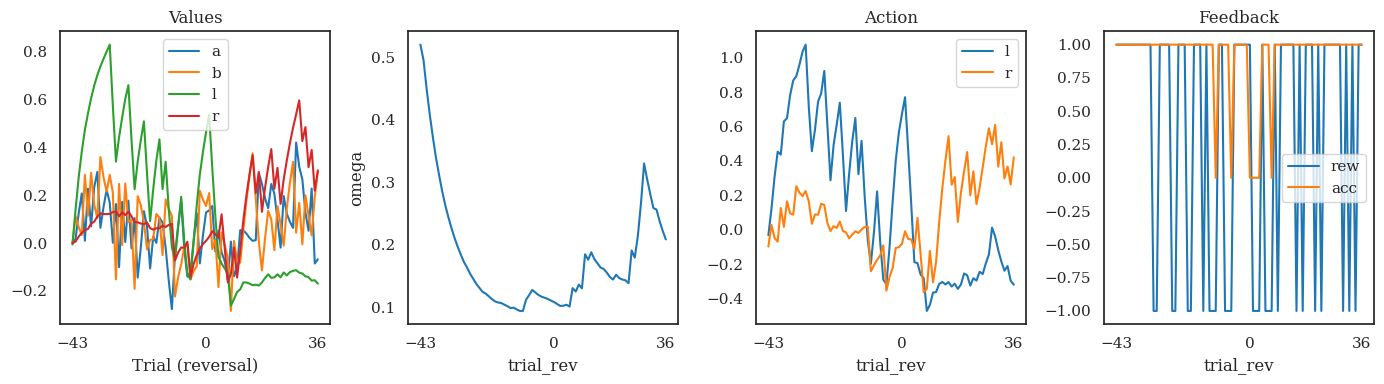

In [7]:
values, spikes = run_dynamics(block=15)
plot_dynamics(values)

In [8]:
def load_spikes_hdf5(filename):
    spikes = {}
    with h5py.File(filename, "r") as f:
        for label in f.keys():
            spikes[label] = {}
            for trial in f[label].keys():
                spikes[label][int(trial)] = f[label][trial][:]
    return spikes

In [13]:
spikes = load_spikes_hdf5("data/nef/monkeyV_session0_block1_spikes.h5")